In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

%matplotlib inline

test_results = pd.read_csv('test_results.csv')
user_table = pd.read_csv('user_table.csv')

In [3]:
test_results.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [4]:
user_table.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [5]:
test_results['converted'].value_counts()
# conversions are very very rare

0    310992
1      5808
Name: converted, dtype: int64

In [6]:
test_results['price'].value_counts()

39    202672
59    114128
Name: price, dtype: int64

In [17]:
# Let's check the fraction of observed conversions at each price point

control_cohort = test_results[test_results.price == 39]
alternative_cohort = test_results[test_results.price == 59]

print('Separate into control and alternative treatment tables: ')
print('Control: ' + str(control_price.shape))
print('Alternative Higher Price: ' + str(alternative_price.shape))

control_conversions = control_cohort[control_cohort.converted == 1]
alternative_conversions = alternative_cohort[alternative_cohort.converted == 1]

print(' ')
print('What about conversions only? ')
print('Control: ' + str(control_conversions.shape))
print('Alternative Higher Price: ' + str(alternative_conversions.shape))

Separate into control and alternative treatment tables: 
Control: (202672, 8)
Alternative Higher Price: (114128, 8)
 
What about conversions only? 
Control: (4031, 8)
Alternative Higher Price: (1777, 8)


In [19]:
control_conversion_rate = len(control_conversions)/len(control_cohort)
print('Control conversion rate: ' + str(control_conversion_rate))

alternative_conversion_rate = len(alternative_conversions)/len(alternative_cohort)
print('Alternative conversion rate: ' + str(alternative_conversion_rate))

Control conversion rate: 0.01988927922949396
Alternative conversion rate: 0.015570236926959203


In [35]:
# Should we sell at $39 or $59?
# Suppose that we do set a single fixed price and show this to 100,000 people
# Assuming that the control and treatment group were randomly specified,
# we estimate the following revenue for the two options:

revenue_control_price = 39*control_conversion_rate*100000
print('Estimated control revenue expected from 100,000 ad placements: ' 
      + str(round(revenue_control_price)) + ' dollars')

revenue_alternative_price = 59*alternative_conversion_rate*100000
print('Estimated alternative revenue expected from 100,000 ad placements: ' 
      + str(round(revenue_alternative_price)) + ' dollars')

print(' ')
print('So, we estimate that revenue will be ' + str(round((revenue_alternative_price/revenue_control_price-1)*100)) 
      + '% higher if we sell at the higher price (while maintaining the mix of current advertising ad placements).')

print(' ')
print('Further, any on-going support costs will be less at the higher price since fewer liscenes are sold.')

Estimated control revenue expected from 100,000 ad placements: 77568 dollars
Estimated alternative revenue expected from 100,000 ad placements: 91864 dollars
 
So, we estimate that revenue will be 18% higher if we sell at the higher price (while maintaining the mix of current advertising ad placements).
 
Further, any on-going support costs will be less at the higher price since fewer liscenes are sold.


**Discussion:** Based on this first-blush analysis, it seems promising to sell the software at the higher price...however, we have not yet considered the variance in conversions for the two treatments (we have used only point estimates for the conversion rate in each group).

So, let's now consider variance. We will continue to focus on the revenue from 100,000 advertisement placements, but we will now use resampling to describe the variance around these estimated revenue figures.

In [85]:
# We will repeatedly resample populations of 20,000 from each group
# to build an estimate of the distribution of profits at both price levels

resampled_control_revenues = []

for index in range(1000):
    resampled_control_cohort = control_cohort.sample(50000)
    resampled_control_conversions = resampled_control_cohort[resampled_control_cohort.converted == 1]
    resampled_control_conversion_rate = len(resampled_control_conversions)/len(resampled_control_cohort)
    resampled_revenue_control_price = 39*resampled_control_conversion_rate*100000
    resampled_control_revenues.append(resampled_revenue_control_price)


77485.2
Lower-bound of confidence interval: 73554
Upper-bound of confidence interval: 81668


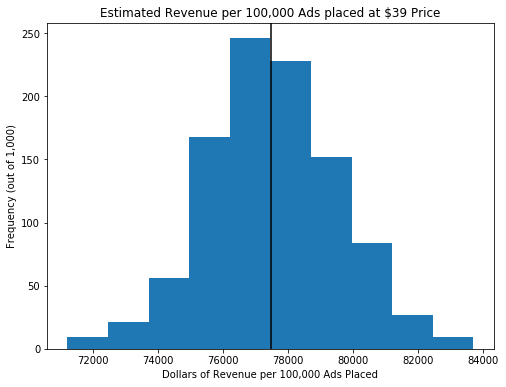

In [86]:
plt.rcParams["figure.figsize"] = (8,6)
plt.hist(resampled_control_revenues)
plt.title('Estimated Revenue per 100,000 Ads placed at $39 Price')
plt.ylabel('Frequency (out of 1,000)')
plt.xlabel('Dollars of Revenue per 100,000 Ads Placed')

resampled_control_revenues = pd.Series(resampled_control_revenues)

plt.axvline(x = resampled_control_revenues.mean(),color ='black')

print(resampled_control_revenues.mean())
print('Lower-bound of confidence interval: ' + str(round(resampled_control_revenues.quantile(0.025))))
print('Upper-bound of confidence interval: ' + str(round(resampled_control_revenues.quantile(0.975))))

In [87]:
# We will repeatedly resample populations of 20,000 from each group
# to build an estimate of the distribution of profits at both price levels

resampled_alternative_revenues = []

for index in range(1000):
    resampled_alternative_cohort = alternative_cohort.sample(50000)
    resampled_alternative_conversions = resampled_alternative_cohort[resampled_alternative_cohort.converted == 1]
    resampled_alternative_conversion_rate = len(resampled_alternative_conversions)/len(resampled_alternative_cohort)
    resampled_revenue_alternative_price = 59*resampled_alternative_conversion_rate*100000
    resampled_alternative_revenues.append(resampled_revenue_alternative_price)

91920.82
Lower-bound of confidence interval: 86963
Upper-bound of confidence interval: 96642


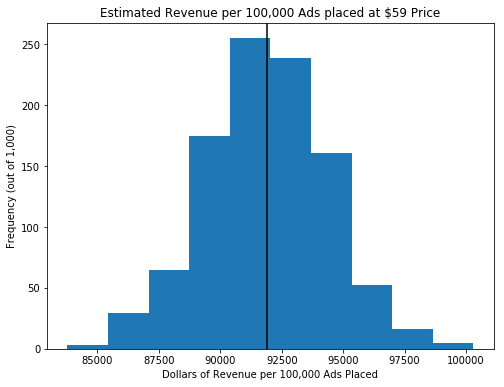

In [88]:
plt.rcParams["figure.figsize"] = (8,6)
plt.hist(resampled_alternative_revenues)
plt.title('Estimated Revenue per 100,000 Ads placed at $59 Price')
plt.ylabel('Frequency (out of 1,000)')
plt.xlabel('Dollars of Revenue per 100,000 Ads Placed')

resampled_alternative_revenues = pd.Series(resampled_alternative_revenues)

plt.axvline(x = resampled_alternative_revenues.mean(),color ='black')

print(resampled_alternative_revenues.mean())
print('Lower-bound of confidence interval: ' + str(round(resampled_alternative_revenues.quantile(0.025))))
print('Upper-bound of confidence interval: ' + str(round(resampled_alternative_revenues.quantile(0.975))))

Text(0.5, 1.0, 'Changing to $59 Price Will Improve Revenues (Estimated Revenue Increase of 18%)')

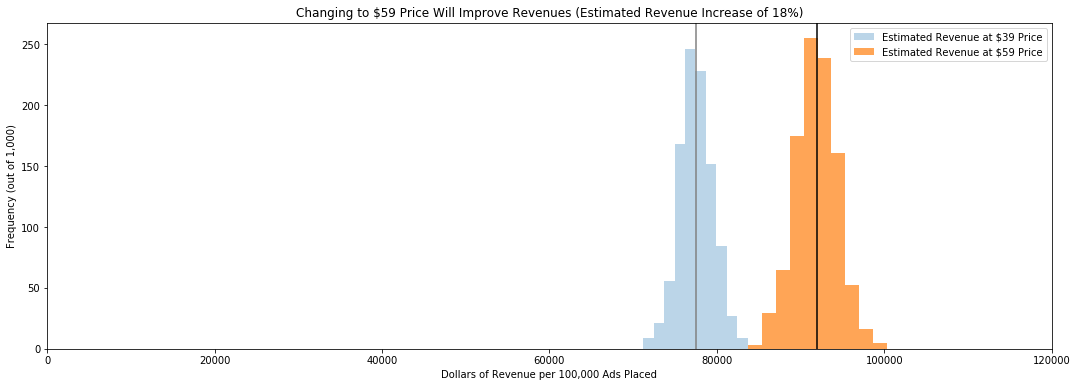

In [117]:
plt.rcParams["figure.figsize"] = (18,6)


plt.hist(resampled_control_revenues, alpha=0.3, label='Estimated Revenue at $39 Price')
plt.hist(resampled_alternative_revenues,alpha=0.7, label='Estimated Revenue at $59 Price')
plt.axvline(x = resampled_control_revenues.mean(),color ='grey')
plt.axvline(x = resampled_alternative_revenues.mean(),color ='black')
plt.ylabel('Frequency (out of 1,000)')
plt.xlabel('Dollars of Revenue per 100,000 Ads Placed')
plt.xlim(0,120000)

plt.legend(loc='upper right')
plt.title('Changing to $59 Price Will Improve Revenues (Estimated Revenue Increase of 18%)')


The analysis above is based on maintaining the same mix of advertisement placements as the company has used over the testing period.

Note: if there are any ongoing support costs that the company has to cover after the point-of-sale, then we expect profits to be increased beyond the estimated revenue gains

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Changing to $59 Price Will Improve Revenues (Estimated Revenue Increase of 18%)')

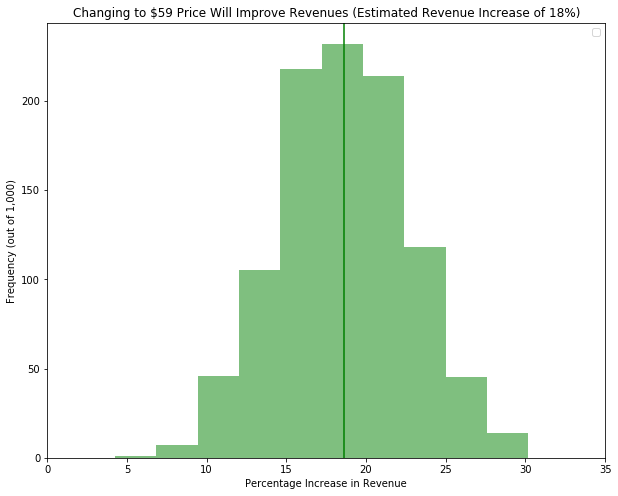

In [124]:
plt.rcParams["figure.figsize"] = (10,8)

rand_differences = []

for index in list(range(len(resampled_control_revenues))):
    rand_differences.append(100*(-resampled_control_revenues[index]+resampled_alternative_revenues[index])/resampled_control_revenues.mean())

rand_differences = pd.Series(rand_differences)    
plt.hist(rand_differences, alpha=0.5,color = "green")
plt.axvline(x = rand_differences.mean(),color ='green')
plt.ylabel('Frequency (out of 1,000)')
plt.xlabel('Percentage Increase in Revenue')
plt.xlim(0,35)

plt.legend(loc='upper right')
plt.title('Changing to $59 Price Will Improve Revenues (Estimated Revenue Increase of 18%)')


In [95]:
rand_differences[:10]

[-13370.000000000015,
 -16561.999999999985,
 -9656.000000000015,
 -11790.0,
 -23366.000000000015,
 -14126.0,
 -11964.0,
 -7594.0,
 -11424.0,
 -13041.999999999985]